In [2]:
# Data Handling and Analysis:

import pandas as pd
import json

# GUI Development:
import tkinter as tk
from tkinter import font
from tkinter import ttk
from tkinter import messagebox
from tkinter import filedialog

# Plotting and Visualisation:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns

# Mapping:
try:
    import folium 
    from folium.plugins import FastMarkerCluster
    FOLIUM_IMPORTED = True
except ImportError:
    FOLIUM_IMPORTED = False


# Browser Interaction:
import webbrowser
import os

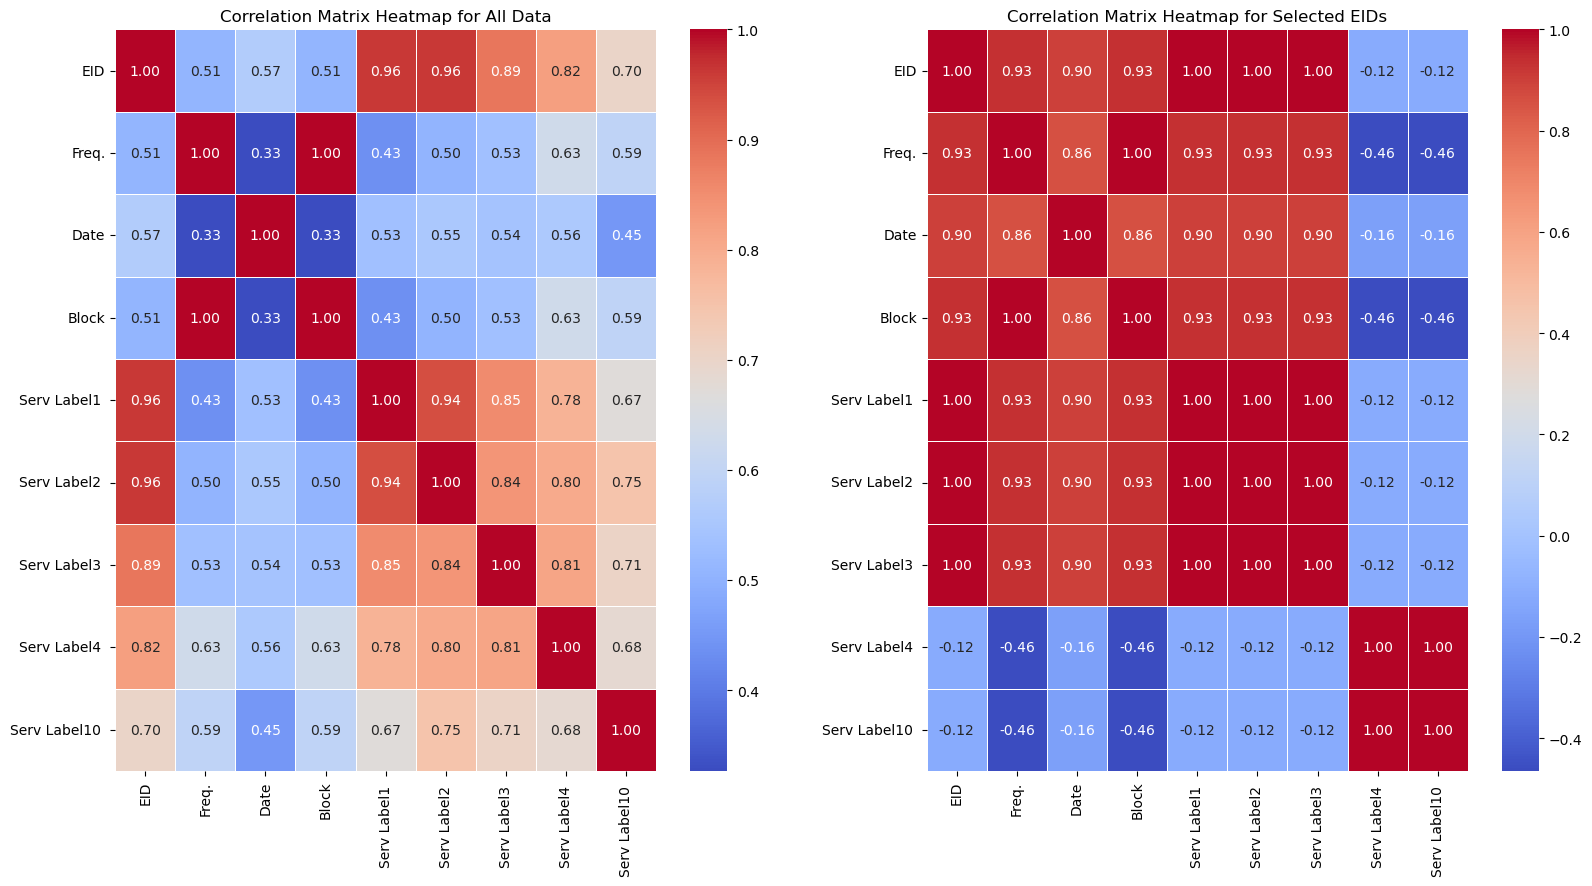

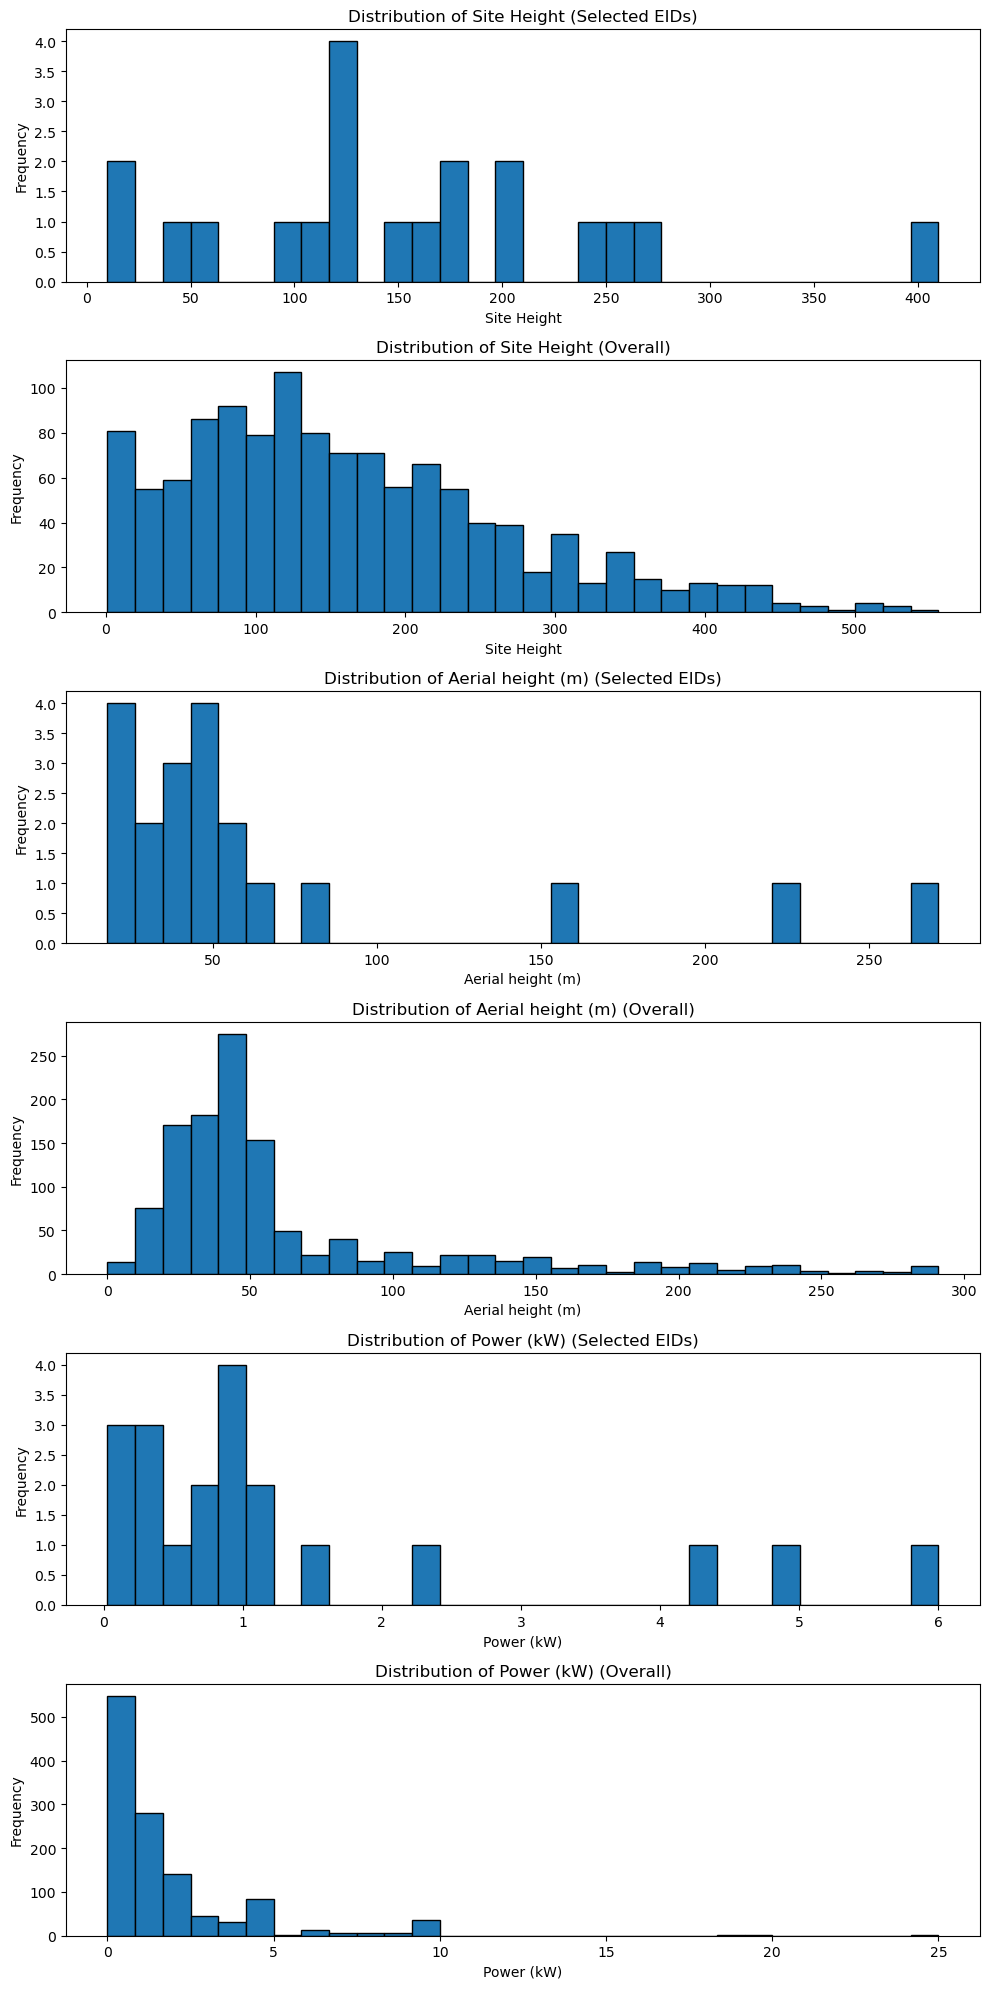

In [4]:
class PageOne(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)
        self.controller = controller
        
        # Create a frame for the title
        title_frame = tk.Frame(self)
        title_frame.pack(fill="x")
        
        label = tk.Label(title_frame, text="UoY - Advanced Programming Summative Assessment", font=controller.title_font)
        label.pack(side="top", fill="x", pady=10)

        # Create a frame for the message and file labels
        file_frame = tk.Frame(self)
        file_frame.pack(fill="x", padx=50, pady=10)

        message_label = tk.Label(file_frame, text="Please choose two files to merge by clicking the load file button", font=controller.normal_font)
        message_label.pack(pady=10)

        self.file_label1 = tk.Label(file_frame, text="", font=controller.normal_font)  # Updated
        self.file_label1.pack()

        self.file_label2 = tk.Label(file_frame, text="", font=controller.normal_font)  # Updated
        self.file_label2.pack()

        # Initialize merged_df
        self.merged_df = None
        
        # Create a frame for the buttons
        button_frame = tk.Frame(self)
        button_frame.pack(fill="x", padx=170, pady=10)

        load_button = tk.Button(button_frame, text="Load Files", command=self.load_files, bg='blue', fg='white', font=controller.normal_font, padx=10, pady=10)
        load_button.pack(side="left", padx=5)

        clean_button = tk.Button(button_frame, text="Clean Data", command=self.clean_data, bg='green', fg='white', font=controller.normal_font, padx=10, pady=10)
        clean_button.pack(side="left", padx=5)

        view_button = tk.Button(button_frame, text="View Data", command=self.view_data, bg='red', fg='white', font=controller.normal_font, padx=10, pady=10)
        view_button.pack(side="left", padx=5)
        
        # Create a frame for the buttons
        button_frame = tk.Frame(self)
        button_frame.pack(side="bottom", fill="x", padx=30)

        # Save JSON button
        save_json_button = tk.Button(button_frame, text="\U0001F4BE", command=self.save_to_json, bg='yellow', fg='black', font=controller.normal_font, padx=10, pady=10)
        save_json_button.pack(side="left", padx=50, pady=75)
        # Save JSON label
        save_json_label = tk.Label(button_frame, text="Save to Json", font=controller.normal_font)
        save_json_label.pack(side="left")

        # Next button
        def go_to_next_page():
            # Check if data has been cleaned and saved to json
            if getattr(controller, "merged_df", None) is not None and controller.data_saved:
                controller.show_frame("PageTwo")
            else:
                messagebox.showerror("Error", "Please load, clean, and save the data before proceeding.")

        next_button = tk.Button(button_frame, text="\u27A1", command=go_to_next_page, bg='purple', fg='white', font=controller.normal_font, padx=10, pady=10)
        next_button.pack(side="right", padx=50, pady=75)
        next_button_label = tk.Label(button_frame, text="Next", font=controller.normal_font)
        next_button_label.pack(side="right")


    def load_files(self):
        file_path1 = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        self.file_label1.config(text=file_path1)

        file_path2 = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        self.file_label2.config(text=file_path2)

        try:
            df1 = pd.read_csv(file_path1, encoding='UTF-8', sep=',')
            df2 = pd.read_csv(file_path2, encoding='ISO-8859-1', sep=',')
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while reading the files. Please load the correct files in the correct order.\n\n1:TxAntennaDAB.csv\n\n2:TxParamsDAB.csv")
            return

        # Check if 'NGR' column exists in the first file and 'Block' column in the second file
        if 'NGR' not in df1.columns or 'Block' not in df2.columns:
            messagebox.showerror("Error", "Please load the correct files in the correct order.\n\n1: TxAntennaDAB.csv\n\n2:TxParamsDAB.csv")
            return

        self.merged_df = pd.merge(df1, df2, on='id')
        messagebox.showinfo("Success", "Files loaded and data merged successfully.")

    def clean_data(self):
    
        # Check if merged_df is empty
        if self.merged_df.empty:
            messagebox.showerror("Error", "The data is empty.")
        else:
        # Data cleaning
            excluded_NGRs = ['NZ02553847', 'SE213515', 'NT05399374', 'NT25265908']
            self.merged_df = self.merged_df[~self.merged_df['NGR'].isin(excluded_NGRs)]
            self.merged_df.rename(columns={'In-Use Ae Ht': 'Aerial height (m)', 'In-Use ERP Total': 'Power (kW)'}, inplace=True)
            self.merged_df['Power (kW)'] = self.merged_df['Power (kW)'].str.replace(',', '').astype(float)
            self.merged_df['Date'] = pd.to_datetime(self.merged_df['Date'], format='%d/%m/%Y')
    
            # Store the cleaned data in the controller
            self.controller.merged_df = self.merged_df
        
            messagebox.showinfo("Success","You data has now been cleaned")
   

    def view_data(self):
        if self.merged_df is None:
            messagebox.showerror("Error", "No data to display. Please load and clean data first.")
            return

        # Create a new window
        new_window = tk.Toplevel(self)
        new_window.title("View Data")
        new_window.geometry("800x500")

        # Create a Treeview in the new window
        tree = ttk.Treeview(new_window)
        
        # Create a Scrollbar and attach it to the treeview
        vsb = ttk.Scrollbar(new_window, orient="vertical", command=tree.yview)
        vsb.pack(side='right', fill='y')
        tree.configure(yscrollcommand=vsb.set)

        hsb = ttk.Scrollbar(new_window, orient="horizontal", command=tree.xview)
        hsb.pack(side='bottom', fill='x')
        tree.configure(xscrollcommand=hsb.set)

        tree["columns"] = list(self.merged_df.columns)
        tree["show"] = "headings"
        for column in tree["columns"]:
            tree.heading(column, text=column)
        tree.pack(side='left', fill='both', expand=True)

        df_rows = self.merged_df.to_numpy().tolist()
        for row in df_rows:
            tree.insert("", "end", values=row)
    
    def save_to_json(self):
        # Convert cleaned data frame to JSON format
        json_cleaned = self.merged_df.to_json(orient='records', date_format='iso', date_unit='s')

        # Writing the JSON data to a file
        with open('cleaned_data.json', 'w') as file:
            file.write(json_cleaned)

        # Opening the JSON file and loading its content
        with open('cleaned_data.json', 'r') as file:
            json_cleaned = json.load(file)

        # Convert list of dictionaries to DataFrame    
            json_cleaned = pd.DataFrame(json_cleaned)
        
        # Store cleaned data in controller
            self.controller.json_cleaned = json_cleaned
        # Set data_saved to True
            self.controller.data_saved = True

        # Inform the user
        messagebox.showinfo("Success", "Data saved to 'cleaned_data.json'.")

class PageTwo(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)
        self.controller = controller
        label = tk.Label(self, text="Data Wrangling")
        label.pack()
        
        
         # Brief Data Wrangling button
        brief_button = tk.Button(self, text="Brief Data Wrangling", command=self.brief_wrangling, bg='green', fg='white', font=controller.normal_font, padx=10, pady=10)
        brief_button.pack(side="top", padx=10, pady=10)

        # Custom Data Wrangling button
        custom_button = tk.Button(self, text="Custom Data Wrangling", command=self.custom_wrangling, bg='blue', fg='white', font=controller.normal_font, padx=10, pady=10)
        custom_button.pack(side="top", padx=10, pady=10)
        
        # Reset button
        reset_button = tk.Button(self, text="Back", command=lambda: controller.show_frame("PageOne"), bg='yellow', fg='black', font=controller.normal_font, padx=10, pady=10)
        reset_button.pack(side="top", padx=10, pady=10)

        # Exit button
        exit_button = tk.Button(self, text="Exit", command=controller.destroy, bg='red', fg='white', font=controller.normal_font, padx=10, pady=10)
        exit_button.pack(side="top", padx=10, pady=10)
        
    def brief_wrangling(self):
    # Access cleaned data from controller
        json_cleaned = self.controller.json_cleaned
        
        # Set the 'EID_vars' attribute in the controller
        self.controller.EID_vars = {'C18A': tk.BooleanVar(value=True), 
                                'C18F': tk.BooleanVar(value=True), 
                                'C188': tk.BooleanVar(value=True)}

        # Join each category to the 'NGR', 'Site', 'Site Height', 'In-Use Ae Ht', 'In-Use ERP Total'
        # Extract rows for each of the DAB multiplexes
        data_C18A = json_cleaned[json_cleaned['EID'] == 'C18A']
        data_C18F = json_cleaned[json_cleaned['EID'] == 'C18F']
        data_C188 = json_cleaned[json_cleaned['EID'] == 'C188']

        DAB1 = data_C18A[['NGR','Date', 'Site', 'Site Height', 'Aerial height (m)', 'Power (kW)','Lat','Long','Block','Freq.','Serv Label1 ','Serv Label2 ', 'Serv Label3 ','Serv Label4 ','Serv Label10 ']]
        DAB2 = data_C18F[['NGR','Date', 'Site', 'Site Height', 'Aerial height (m)', 'Power (kW)','Lat','Long','Block','Freq.','Serv Label1 ','Serv Label2 ', 'Serv Label3 ','Serv Label4 ','Serv Label10 ']]
        DAB3 = data_C188[['NGR','Date', 'Site', 'Site Height', 'Aerial height (m)', 'Power (kW)','Lat','Long','Block','Freq.','Serv Label1 ','Serv Label2 ', 'Serv Label3 ','Serv Label4 ','Serv Label10 ']]

        # Storing in a list to allow for easier manipulation
        EID_data = [DAB1, DAB2, DAB3]  
        

        # Create a new window
        new_window = tk.Toplevel(self)
        new_window.title("Brief Data Wrangling")
        new_window.geometry("750x320")

        # Create a Treeview in the new window
        tree = ttk.Treeview(new_window)

        # Create a Scrollbar and attach it to the treeview
        vsb = ttk.Scrollbar(new_window, orient="vertical", command=tree.yview)
        vsb.pack(side='right', fill='y')
        tree.configure(yscrollcommand=vsb.set)

        hsb = ttk.Scrollbar(new_window, orient="horizontal", command=tree.xview)
        hsb.pack(side='bottom', fill='x')
        tree.configure(xscrollcommand=hsb.set)

        # Set the columns of the Treeview to the columns of the DataFrame
        tree["columns"] = list(DAB1.columns)
        tree["show"] = "headings"
        for column in tree["columns"]:
            tree.heading(column, text=column)

        # Insert the rows of each DataFrame into the Treeview
        for data in EID_data:
            df_rows = data.to_numpy().tolist()
            for row in df_rows:
                tree.insert("", "end", values=row)

        tree.pack(side='left', fill='both', expand=True)

        # Navigate to PageThree
        self.controller.show_frame("PageThree")

        
    def custom_wrangling(self):
        # Access cleaned data from controller
        json_cleaned = self.controller.json_cleaned

        # Create a new window
        new_window = tk.Toplevel(self)
        new_window.title("Custom Data Wrangling")
        new_window.geometry("800x500")

        # Get unique 'EID' values
        unique_EIDs = json_cleaned['EID'].unique()

        # Create a dictionary to store BooleanVars for each 'EID'
        self.controller.EID_vars = {EID: tk.BooleanVar() for EID in unique_EIDs}        

        # Create a frame for the checkboxes
        checkbox_frame = ttk.Frame(new_window)
        checkbox_frame.pack(side="top", fill="both")
        
        # Create a checkbox for each 'EID' and arrange them in a grid
        for i, EID in enumerate(unique_EIDs):
            cb = ttk.Checkbutton(checkbox_frame, text=EID, variable=self.controller.EID_vars[EID])
            cb.grid(row=i // 10, column=i % 10)

        # Create a button to filter the dataset
        filter_button = tk.Button(new_window, text="Filter Data", command=self.filter_data, bg='green', fg='white')
        filter_button.pack(side="left", padx=10, pady=10)

        next_button = tk.Button(new_window, text="\u27A1", command=self.destroy, bg='purple', fg='white', font=self.controller.normal_font, padx=10, pady=10)
        next_button.pack(side="right", padx=10, pady=10)
        next_button_label = tk.Label(new_window, text="Next")
        next_button_label.pack(side="right")
        

    def filter_data(self):
        # Access cleaned data from controller
        json_cleaned = self.controller.json_cleaned
        

        # Filter the data based on the checked 'EID' values
        checked_EIDs = [EID for EID, var in self.controller.EID_vars.items() if var.get()]

        # Select certain columns from each filtered DataFrame
        columns_to_select = ['NGR', 'Site', 'Site Height', 'Aerial height (m)', 'Power (kW)','Lat','Long']
        EID_data = []
        for EID in checked_EIDs:
            filtered_data = json_cleaned[json_cleaned['EID'] == EID]
            selected_data = filtered_data[columns_to_select]
            EID_data.append(selected_data)

        # Concatenate all DataFrames in EID_data into a single DataFrame
        EID_data_combined = pd.concat(EID_data)
        
        # Create a new window for the Treeview
        treeview_window = tk.Toplevel(self)
        treeview_window.title("EID Data")
        treeview_window.geometry("750x320")

        # Create a Treeview in the new window
        tree = ttk.Treeview(treeview_window)
        
        # Create a Scrollbar and attach it to the treeview
        vsb = ttk.Scrollbar(treeview_window, orient="vertical", command=tree.yview)
        vsb.pack(side='right', fill='y')
        tree.configure(yscrollcommand=vsb.set)

        hsb = ttk.Scrollbar(treeview_window, orient="horizontal", command=tree.xview)
        hsb.pack(side='bottom', fill='x')
        tree.configure(xscrollcommand=hsb.set)

        # Set the columns of the Treeview to the columns of the DataFrame
        tree["columns"] = list(EID_data_combined.columns)
        tree["show"] = "headings"
        for column in tree["columns"]:
            tree.heading(column, text=column)

        # Insert the rows of the DataFrame into the Treeview
        df_rows = EID_data_combined.to_numpy().tolist()
        for row in df_rows:
            tree.insert("", "end", values=row)

        tree.pack(side='left', fill='both', expand=True)
         # Navigate to PageThree
        self.controller.show_frame("PageThree")

class PageThree(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)
        self.controller = controller
        label = tk.Label(self, text="Data Analysis")
        label.pack()
        
        # Title label
        label = tk.Label(self, text="Page Three", font=controller.title_font)
        label.pack(side="top", fill="x", pady=10)

        # Button 1
        button1 = tk.Button(self, text="Site Mean, Median and Modes",command=self.calculate_stats, bg='green', fg='white', padx=10, pady=10)
        button1.pack(side="top", padx=10, pady=10)

        # Button 2
        button2 = tk.Button(self, text="Geospatial Overview",command=self.create_map, bg='green', fg='white', padx=10, pady=10)
        button2.pack(side="top", padx=10, pady=10)

        # Button 3
        button3 = tk.Button(self, text="Time series",command=self.plot_time_series, bg='green', fg='white', padx=10, pady=10)
        button3.pack(side="top", padx=10, pady=10)

        # Button 4
        button4 = tk.Button(self, text="Correlation Plot",command=self.plot_correlation_matrix , bg='green', fg='white', padx=10, pady=10)
        button4.pack(side="top", padx=10, pady=10)

        # Button 5
        button5 = tk.Button(self, text="Site Height, Aerial Height and Power distribution", command=self.plot_SHP_histograms, bg='green', fg='white', padx=10, pady=10)
        button5.pack(side="top", padx=10, pady=10)

        # Exit button
        exit_button = tk.Button(self, text="Exit",command=self.controller.destroy, bg='red', fg='white', padx=10, pady=10)
        exit_button.pack(side="right", padx=10, pady=10)
        
        # Save to JSON button
        save_button = tk.Button(self, text="Save to JSON", command=self.save_to_json, bg='blue', fg='white', padx=10, pady=10)
        save_button.pack(side="bottom", anchor='w', padx=10, pady=10)
        
   
    def calculate_stats(self):
        # Access cleaned data from controller
        json_cleaned = self.controller.json_cleaned

        # Convert 'Date' column to datetime
        json_cleaned['Date'] = pd.to_datetime(json_cleaned['Date'])

        # Filter data for 'Site Height' more than 75
        filtered_data_over_75 = json_cleaned[json_cleaned['Site Height'] > 75]
        # Filter data for 'Date' from 2001 onwards
        filtered_data_from_2001 = json_cleaned[json_cleaned['Date'].dt.year >= 2001]

        # Get the checked 'EID' values
        checked_EIDs = [EID for EID, var in self.controller.EID_vars.items() if var.get()]

        # Create a new window to show the results
        results_window = tk.Toplevel(self)
        results_window.title("Results")

        for EID in checked_EIDs:
            # Extract the relevant DAB multiplex for over 75 height
            filtered_EID_over_75 = filtered_data_over_75[filtered_data_over_75['EID'] == EID]
            # Extract the relevant DAB multiplex for 2001 onwards
            filtered_EID_from_2001 = filtered_data_from_2001[filtered_data_from_2001['EID'] == EID]

            # Calculate the mean, mode, and median for the 'Power (kW)' for each DAB multiplex for over 75 height
            EID_stats_over_75 = {
            'Mean': round(filtered_EID_over_75['Power (kW)'].mean(), 3),
            'Mode': round(filtered_EID_over_75['Power (kW)'].mode()[0], 3) if not filtered_EID_over_75['Power (kW)'].mode().empty else None,
            'Median': round(filtered_EID_over_75['Power (kW)'].median(), 3)
            }
            # Calculate the mean, mode, and median for the 'Power (kW)' for each DAB multiplex for 2001 onwards
            EID_stats_from_2001 = {
            'Mean': round(filtered_EID_from_2001['Power (kW)'].mean(), 3),
            'Mode': round(filtered_EID_from_2001['Power (kW)'].mode()[0], 3) if not filtered_EID_from_2001['Power (kW)'].mode().empty else None,
            'Median': round(filtered_EID_from_2001['Power (kW)'].median(), 3)
            }

            # Add labels to the window for each piece of information for over 75 height
            tk.Label(results_window, text=f"{EID} (Site Height > 75) Power (kW) Mean: {EID_stats_over_75['Mean']}, Mode: {EID_stats_over_75['Mode']}, Median: {EID_stats_over_75['Median']}\n").pack()

            # Add labels to the window for each piece of information for 2001 onwards
            tk.Label(results_window, text=f"{EID} (Date from 2001 onwards) Power (kW) Mean: {EID_stats_from_2001['Mean']}, Mode: {EID_stats_from_2001['Mode']}, Median: {EID_stats_from_2001['Median']}\n").pack()


    # Button 2:
    def create_map(self):
        
        # Check if folium is imported
        if not FOLIUM_IMPORTED:
            messagebox.showerror("Error", "Folium module is not available. Cannot generate maps.")
            return
        # Access cleaned data from controller
        merged_df = self.controller.merged_df

        # Filter the data based on the checked 'EID' values
        checked_EIDs = [EID for EID, var in self.controller.EID_vars.items() if var.get()]

        # Ask for user confirmation
        user_response = messagebox.askyesno("Confirmation", "The maps will be opened in new browser windows. Are you okay with this?")

        if user_response:
            # User confirmed, generate maps

            # Create a map centered at an average location
            m = folium.Map(location=[merged_df['Lat'].mean(), merged_df['Long'].mean()], zoom_start=10)

            # Prepare data for FastMarkerCluster
            locations = merged_df[['Lat', 'Long']].values.tolist()
            popups = merged_df['Site'].values.tolist()
            
            # Open the analysis window directly
            self.show_Geo_analysis()

            # Add FastMarkerCluster to the map
            m.add_child(FastMarkerCluster(locations, popups=popups))

            # Save the map to an HTML file
            m.save("cluster_map.html")

            # Open the HTML file in the web browser
            webbrowser.open("file://" + os.path.realpath("cluster_map.html"), new=2)

            # Create a new map centered at an average location
            m2 = folium.Map(location=[merged_df['Lat'].mean(), merged_df['Long'].mean()], zoom_start=7)

            # Add a marker for each location to the map
            for EID in checked_EIDs:
                data = merged_df[merged_df['EID'] == EID]
                color = 'red' if EID == 'C18A' else 'green' if EID == 'C18F' else 'blue'
                for _, row in data.iterrows():
                    folium.Marker([row['Lat'], row['Long']], popup=row['Site'], icon=folium.Icon(color=color)).add_to(m2)

            # Save the new map to a different HTML file
            m2.save("markers_map.html")

            # Open the new HTML file in the web browser
            webbrowser.open("file://" + os.path.realpath("markers_map.html"), new=2)
            
        else:
            # User did not confirm, do nothing or provide alternative action
            pass
        
    def show_Geo_analysis(self):
        # Analysis text
        analysis_text = "*Please not that this is only relevant to the given brief*\n\nDiverse Distribution:\nThe EIDs are spread across three distinct cities, with no apparent pattern or resemblance linking them geographically. This diversity could suggest that the EIDs are associated with different services, providers, or functions within these cities.\n\nCity-wise Count:\nEdinburgh (7): The presence of 7 EIDs in Edinburgh could indicate a higher concentration or demand for the services associated with these EIDs in this city. This could be influenced by factors such as population density, technological infrastructure, or specific regional needs.\n\nLeeds (3): With only 3 EIDs, Leeds appears to have a lesser association with these identifiers. This could be indicative of different service requirements, technological adoption rates, or other localized factors.\n\nNewcastle (11): The highest count of EIDs is found in Newcastle, signifying a potentially significant role for the services related to these EIDs within this city. This may reflect specific industrial, commercial, or cultural aspects of Newcastle that align with the functions of these EIDs."

        # Create a new window for the analysis
        analysis_window = tk.Toplevel(self)
        analysis_window.title("Analysis")

        # Label to display the analysis text
        analysis_label = tk.Label(analysis_window, text=analysis_text, wraplength=400, justify='left')
        analysis_label.pack(padx=10, pady=10)
        
    # Button 3:
    
    def plot_time_series(self):
    
        # Access cleaned data from controller
        json_cleaned = self.controller.json_cleaned

        # Convert 'Date' column to datetime
        json_cleaned['Date'] = pd.to_datetime(json_cleaned['Date'])

        # Set 'Date' as the index for time series analysis
        json_cleaned.set_index('Date', inplace=True)

        # Get the EIDs that were checked in the custom_wrangling method
        checked_EIDs = [EID for EID, var in self.controller.EID_vars.items() if var.get()]

        # Create a new window
        new_window = tk.Toplevel(self)
        new_window.title("Time Series Analysis")
        new_window.transient(self)

        # Function to show brief analysis
        def show_time_analysis():
            analysis_window = tk.Toplevel(self)
            analysis_window.title("Brief Analysis")
            analysis_text = "Overall Broadcasting Trends (All DAB)\n\nGeneral Trend:\nThere's a clear upward trend in the number of broadcasts from 2001 to 2021, indicating increased activity or popularity in DAB.\n\nPossible Seasonality: Some periodic fluctuations suggest possible seasonality, which may require further investigation to identify specific seasonal patterns (e.g., summer or winter programming).\n\nSpecific EIDs - Radio Stations:\n\nEID C18A: This station has a more pronounced upward trend, particularly from 2005 to 2012, suggesting a period of growth or successful programming. The decline afterward may indicate changes in content, audience preferences, or competition.\n\nEID C18F: This station shows a more consistent pattern with slight fluctuations. It might be targeting a stable audience or maintaining a consistent content strategy.\n\nEID C188: With a significant rise from 2001 to 2006, followed by a sharp decline, this station's pattern may indicate a specific event, change in content, or market shift that affected its broadcasts.\n\nComparison Between Overall and Specific Trends:\nAlignment with Overall Trend: The specific EIDs seem to contribute to the overall upward trend, reflecting the general growth in DAB.\n\nDifferences Among EIDs:\nThe distinct patterns of the three EIDs suggest different strategies, content, or market positioning."
            analysis_label = tk.Label(analysis_window, text=analysis_text, justify=tk.LEFT, wraplength=800)
            analysis_label.pack(expand=tk.YES, fill=tk.BOTH)

        # Create a button to view brief analysis
        analysis_button = tk.Button(new_window, text="View Analysis (Brief Only)", command=show_time_analysis)
        analysis_button.pack(side=tk.TOP, padx=10, pady=10)

        # Create a combo box to switch between the EIDs
        EIDs = ["All User Selected Data"] + ["All EID Data"] + checked_EIDs
        combo_box = ttk.Combobox(new_window, values=EIDs, state="readonly")
        combo_box.pack(side=tk.TOP)

        # Create a Figure for the plot
        fig = Figure(figsize=(12, 6), dpi=100)

        # Add a subplot to the Figure
        ax = fig.add_subplot(111)
        
        # Function to update the plot
        def update_plot(EID):
            # Clear the subplot
            ax.clear()

            if EID == "All User Selected Data":
            # Filter the data for the checked EIDs and years from 2001 onwards
                data_EID = json_cleaned[(json_cleaned['EID'].isin(checked_EIDs)) & (json_cleaned.index.year >= 2001)]
                title = 'Number of Broadcasts Over Time for All Selected EIDs'
            elif EID == "All EID Data":
            # Filter the data for years from 2001 onwards
                data_EID = json_cleaned[json_cleaned.index.year >= 2001]
                title = 'Number of Broadcasts Over Time for All EIDs'
            else:
            # Filter the data for the selected EID
                data_EID = json_cleaned[json_cleaned['EID'] == EID]
                title = 'Number of Broadcasts Over Time for ' + EID

            # Resample the data by month and count the number of broadcasts
            monthly_broadcasts = data_EID.resample('M').size()

            # Plot the number of broadcasts over time
            monthly_broadcasts.plot(ax=ax)

            ax.set_title(title)
            ax.set_xlabel('Date')
            ax.set_ylabel('Number of Broadcasts')

            # Update the Figure on the canvas
            canvas.draw()

        # Create a canvas for the Figure
        canvas = FigureCanvasTkAgg(fig, master=new_window)
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

        combo_box.bind("<<ComboboxSelected>>", lambda event: update_plot(combo_box.get()))

        # Show the plot for "All EID Data" by default
        combo_box.current(1)
        update_plot("All EID Data") 

    # Button 4: 
    def plot_correlation_matrix(self):
        # Access cleaned data from controller
        json_cleaned = self.controller.json_cleaned

        # Reset the index to make 'Date' available as a regular column
        json_cleaned = json_cleaned.reset_index()

        # Now you can select the desired columns
        selected_columns = ['EID','Freq.', 'Date', 'Block', 'Serv Label1 ', 'Serv Label2 ', 'Serv Label3 ', 'Serv Label4 ', 'Serv Label10 ']
        json_cleaned = json_cleaned[selected_columns]
        
        # Get the EIDs that were checked in the custom_wrangling method
        checked_EIDs = [EID for EID, var in self.controller.EID_vars.items() if var.get()]

        # Filter the data for the checked EIDs
        EID_data = json_cleaned[json_cleaned['EID'].isin(checked_EIDs)]

        # Convert categorical columns to numerical using factorize
        EID_data_encoded = EID_data.apply(lambda x: pd.factorize(x)[0])
        all_encoded = json_cleaned.apply(lambda x: pd.factorize(x)[0])

        # Calculate the correlation matrix
        correlation_matrix_EID = EID_data_encoded.corr()
        correlation_matrix_all = all_encoded.corr()

        # Create a new window
        new_window = tk.Toplevel(self)
        new_window.title("Correlation Matrix Heatmap")
        
        # Add button to open analysis window
        analysis_button = tk.Button(new_window, text="View Analysis (Brief Only)", command=self.show_corr_analysis)
        analysis_button.pack(side=tk.TOP, padx=10, pady=10)

        # Create a Figure for the plot
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))

        # Plot the correlation matrix for all data
        sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[0])
        axes[0].set_title('Correlation Matrix Heatmap for All Data')

        # Plot the correlation matrix for the selected EIDs
        sns.heatmap(correlation_matrix_EID, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[1])
        axes[1].set_title('Correlation Matrix Heatmap for Selected EIDs')

        # Create a canvas for the Figure
        canvas = FigureCanvasTkAgg(fig, master=new_window)
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

        canvas.draw()
        
    def show_corr_analysis(self):
        # Create a new window for analysis
        analysis_window = tk.Toplevel(self)
        analysis_window.title("Analysis")

        # Add analysis
        analysis_text = "Freq. and Block:\nThe correlation is 1, indicating that they are perfectly correlated. This relationship is expected, as each block designation corresponds to a specific set of frequencies used for broadcasting.\n\nFreq./Block and Service Labels (Serv Label1, Serv Label2, etc.):\nThese have a mix of positive and negative correlation, which may suggest that certain shows or services are associated with specific frequency ranges. This could be related to licensing, regional broadcasting preferences, or other strategic decisions.\n\nService Labels Interrelation:\nThe mixed correlations between different service labels (e.g., Serv Label1, Serv Label2, etc.) may indicate relationships between different radio shows or services.\n\n"
        analysis_label = tk.Label(analysis_window, text=analysis_text, wraplength=1000,justify=tk.LEFT)
        analysis_label.pack(side=tk.LEFT, padx=10, pady=10)
    
    # Button 5:
    def plot_SHP_histograms(self):
        # Access cleaned data from controller
        json_cleaned = self.controller.json_cleaned

        # Select the desired columns
        cols_to_plot = ['Site Height', 'Aerial height (m)', 'Power (kW)']

        # Filter by the selected EIDs
        checked_EIDs = [EID for EID, var in self.controller.EID_vars.items() if var.get()]
        EID_data = json_cleaned[json_cleaned['EID'].isin(checked_EIDs)]

        # Create a new window
        new_window = tk.Toplevel(self)
        new_window.title("Histograms")
        
        # Function to show analysis
        def show_analysis():
            analysis_window = tk.Toplevel(new_window)
            analysis_window.title("Analysis")
            analysis_text = "Site Height:\nSelected EIDs: Most values are concentrated around the lower range, with a few exceptions.\nOverall: The distribution is slightly more spread out, indicating more variation in site heights across all EIDs.\n\nAerial Height (m):\nSelected EIDs: The distribution resembles a normal distribution, with a peak around the middle values.\nOverall: The overall distribution is similar to the selected EIDs, but with some additional variations.\n\nPower (kW):\nSelected EIDs: Most of the power values are concentrated around the lower range.\nOverall: The overall distribution shows a similar pattern but includes some higher power values."
            analysis_label = tk.Label(analysis_window, text=analysis_text, wraplength=800, justify="left")
            analysis_label.pack(side=tk.LEFT, padx=10, pady=10)

        # Button to view analysis
        analysis_button = tk.Button(new_window, text="View Analysis (Brief Only)", command=show_analysis)
        analysis_button.pack(side=tk.TOP, padx=10, pady=10)

        # Create a canvas for the window with a vertical scrollbar
        canvas_window = tk.Canvas(new_window, scrollregion=(0, 0, 0, 2000))
        canvas_window.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        scrollbar = tk.Scrollbar(new_window, orient="vertical", command=canvas_window.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        canvas_window.configure(yscrollcommand=scrollbar.set)

        # Create a frame inside the canvas
        frame_canvas = tk.Frame(canvas_window)
        canvas_window.create_window((0, 0), window=frame_canvas, anchor='nw')

        # Create a Figure for the plot
        fig, ax = plt.subplots(len(cols_to_plot) * 2, 1, figsize=(10, 20))

        # Loop over the columns and create a histogram for each one
        for i, col in enumerate(cols_to_plot):
            # Histogram for selected EIDs
            ax[i * 2].hist(EID_data[col].dropna(), bins=30, edgecolor='black')
            ax[i * 2].set_title(f'Distribution of {col} (Selected EIDs)')
            ax[i * 2].set_xlabel(col)
            ax[i * 2].set_ylabel('Frequency')

            # Histogram for overall dataset
            ax[i * 2 + 1].hist(json_cleaned[col].dropna(), bins=30, edgecolor='black')
            ax[i * 2 + 1].set_title(f'Distribution of {col} (Overall)')
            ax[i * 2 + 1].set_xlabel(col)
            ax[i * 2 + 1].set_ylabel('Frequency')

        # Adjust the layout for better spacing
        fig.tight_layout()

        # Create a canvas for the Figure
        canvas_plot = FigureCanvasTkAgg(fig, master=frame_canvas)
        canvas_plot.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

        canvas_plot.draw()

        # Update the canvas size
        frame_canvas.update_idletasks()
        canvas_window.config(scrollregion=canvas_window.bbox("all"))

        new_window.geometry("1020x600") 
    
    # Button 7:
    def save_to_json(self):
        # Ask the user if they want to overwrite the original file
        response = messagebox.askyesnocancel("Save to JSON", "Do you want to overwrite the original file? Choosing 'No' will save to a new file named 'new_cleaned_data.json'.")
    
        # If the user clicked 'Yes', overwrite the original file
        if response is True:
            self.controller.merged_df.to_json("cleaned_data.json")
            messagebox.showinfo("Success", "Data overwritten to cleaned_data.json.")
    
    # If the user clicked 'No', save to a new file
        elif response is False:
            self.controller.merged_df.to_json("new_cleaned_data.json")
            messagebox.showinfo("Success", "Data saved to new_cleaned_data.json.")

    # If the user clicked 'Cancel' or closed the dialog, do nothing
        else:
            pass     
    

class MainApplication(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.title("UoY: Advanced Programming - Summative Assessment")
        self.geometry("760x470")
        container = tk.Frame(self)
        container.pack(side="top", fill="both", expand=True)
        self.title_font = font.Font(family='Helvetica', size=18, weight="bold")
        self.normal_font = font.Font(family='Helvetica', size=12)
        # Add new attribute
        self.data_saved = False

        self.frames = {}
        for F in (PageOne, PageTwo, PageThree):
            frame = F(container, self)
            self.frames[F.__name__] = frame
            frame.grid(row=0, column=0, sticky="nsew")

        self.show_frame("PageOne")

    def show_frame(self, name):
        frame = self.frames[name]
        frame.tkraise()
    
app = MainApplication()
app.mainloop()